<a href="https://colab.research.google.com/github/valmirf/redes_neurais_pos/blob/main/CNN/Lenet_e_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch

Veremos agora o uso da biblioteca PyTorch pra implementar o Lenet. Hoje em dia, em torno de 80% dos trabalhos com redes neurais utilizam essa biblioteca e outros 20%, utilizam o TensorFlow. Essa biblioteca encapsula o TensorFlow, porém, dá uma boa liberdade para o desenvolvedor ajustar o modelo criado. 


Na primeira parte, são importados todas as bibliotecas que iremos precisar para construir nossa primeira rede neural com o PyTorch.

In [ ]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms


import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

Nessa outra parte do código, colocamos alguns parâmetros da rede neural, como taxa de aprendizado, tamanho do lote, número de épocas. 

Outros parâmetros importantes são o tamanho da entrada, que é relacionado ao tamanho da matriz de entrada e o número de classes que produzirá a resposta final.

In [ ]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [ ]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

##Construindo a Rede Neural


O módulo torch.nn.Module é o principal no design da arquitetura da rede neural no PyTorch. O PyTorch fornece vários tipos de camadas. Essa classe pode ser usada para implementar uma camada como uma camada totalmente conectada, uma camada convolucional, uma camada de pool, uma função de ativação e também uma rede neural inteira, instanciando um objeto torch.nn.Module. 

Vários objetos nn.Module podem ser agrupados para formar um objeto nn.Module maior, que é como podemos implementar uma rede neural usando várias camadas. 

A classe nn.Module possui dois métodos que você deve substituir:

*A  função __init__ - Esta função é chamada quando você cria uma instância do nn.Module. Aqui você definirá os vários parâmetros de uma camada, como filtros, tamanho do kernel para uma camada convolucional, probabilidade do dropout.

*A função forward - É aqui que você define como sua saída é calculada. Essa função não precisa ser chamada explicitamente e pode ser executada apenas chamando a instância nn.Module como uma função com a entrada como argumento.

*Outra* classe amplamente usada é a classe nn.Sequential. Ao iniciar esta classe, podemos passar uma lista de objetos nn.Module em uma sequência específica. O objeto retornado por nn.Sequential é um objeto nn.Module. Quando esse objeto é executado com uma entrada, ele executa a entrada sequencialmente em todo o objeto nn.Module que passamos para ele, na mesma ordem em que passamos por eles.

##**Lenet**


LeNet-5 é uma rede neural convolucional de 7 camadas, treinada em imagens em tons de cinza de tamanho 32 x 32 pixels.



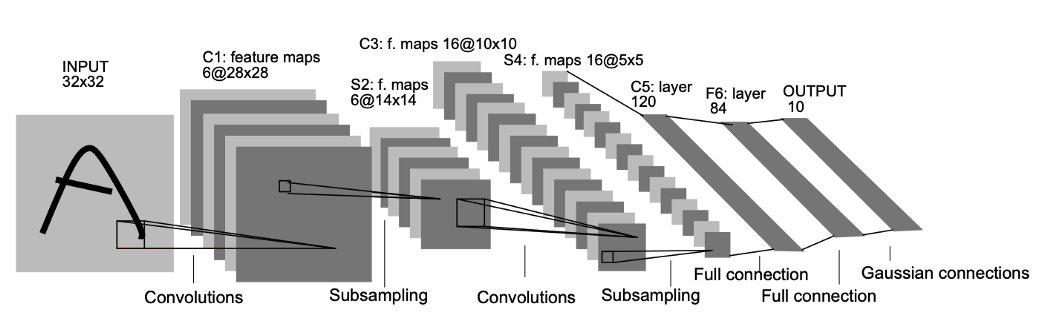

Note a mudança de dimensões em cada camada. Porque após a entrada, a camada tem dimensão 28x28x6? 

**Camada 1 (C1)**: A primeira camada convolucional com 6 núcleos de tamanho 5×5.

**Camada 2 (S2)**: Uma camada de subamostragem/pooling com 6 filtros de tamanho 2×2 e stride 2.

**Camada 3 (C3)**: A segunda camada convolucional com a mesma configuração da primeira, porém, desta vez com 16 filtros. 

**Camada 4 (S4)**: A segunda camada de pooling. A lógica é idêntica à anterior, mas desta vez a camada possui 16 filtros. 

**Camada 5 (C5)**: A última camada convolucional com 120 filtros de tamanho 5×5. Dado que a entrada para esta camada é de tamanho 5×5×16 e os núcleos são de tamanho 5×5, a saída é de 1×1×120. Ou seja, transforma os dados pra um vetor que servirá como entrada da primeira camada totalmente conectada.

**Camada 6 (F6)**: A primeira camada totalmente conectada, que recebe a entrada de 120 atributos e retorna 84 atributos. 

**Camada 7 (F7)**: A última camada densa, produz 10 atributos. 

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1) #transforma a matrix x em vetor.
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

##*Mini-VGG*

A arquitetura da Mini-VGG é uma simplificação da arquitetura da rede VGG. Ela possui 11 camadas distribuídas em blocos de Camadas de Convolução e Normalização de Lotes, e depois Camadas Totalmente Conectadas.

-----------------------------------
Convolução com 64 filtros

Convolução com 64 filtros + Batch Normalization

Convolução com 128 filtros

Convolução com 128 filtros + Batch Normalization


Convolução com 256 filtros

Convolução com 256 filtros + Batch Normalization

Convolução com 512 filtros + Batch Normalization

Totalmente Conectada com 4096 nós

Totalmente Conectada com 128 nós

Camada de saída com função de ativação Softmax com 64 nós

---------------------------------------

In [ ]:
#=========================================>
#   < Building the Network >
#=========================================>

class VGG_mini(nn.Module):
    
    def __init__(self, n_classes): 
        super(VGG_mini, self).__init__()
        
        # Maxpool 2x2
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Conv layers with batch norm
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding = 1)
        self.norm1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 64, 3, padding = 1)
        self.norm2 = nn.BatchNorm2d(64)
               
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        self.norm3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, 3, padding = 1)
        self.norm4 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
        self.norm5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(256, 256, 3, padding = 1)
        self.norm6 = nn.BatchNorm2d(256)

        self.conv7 = nn.Conv2d(256, 512, 3, padding = 1)
        self.norm7 = nn.BatchNorm2d(512)
        
        self.conv8 = nn.Conv2d(512, 512, 3, padding = 1)
        self.norm8 = nn.BatchNorm2d(512)
        
        # fully connected layer with batch norm

        self.fc1 = nn.Linear(512 * 4 * 4, 128)
        self.norm9 = nn.BatchNorm1d(128)
       
        self.fc2 = nn.Linear(128, 64)
        self.norm10 = nn.BatchNorm1d(64)
        
        self.fc3 = nn.Linear(64, n_classes)
        

    def forward(self, x):       
        
        out = F.elu(self.norm1(self.conv1(x)))
        out = F.elu(self.norm2(self.conv2(out)))
        out = self.pool(out)
        
        out = F.elu(self.norm3(self.conv3(out)))
        out = F.elu(self.norm4(self.conv4(out)))
        out = self.pool(out)
        
        out = F.elu(self.norm5(self.conv5(out)))
        out = F.elu(self.norm6(self.conv6(out)))
        out = self.pool(out)
        
        out = F.elu(self.norm7(self.conv7(out)))
        out = F.elu(self.norm8(self.conv8(out)))
        
        out = out.view(-1, 512 * 4 * 4)
        
        out = F.elu(self.norm9(self.fc1(out)))
        out = F.elu(self.norm10(self.fc2(out)))
        out = self.fc3(out)
        probs = F.softmax(out, dim=1)

        return out, probs

## Define o algoritmo de treinamento.

Para cada lote de observações, realizamos as seguintes etapas:

1. Executar o passo *foward* - obtendo as previsões para o lote usando os pesos atuais.

2. Calcular o valor da função de perda

3. Executar o passo *backward*, no qual os pesos são ajustados com base na perda. Esta é a etapa de “aprendizado”.

Observe que para a fase de treinamento, o modelo está no modo de treinamento (model.train()) e também é preciso zerar os gradientes de cada lote. Além disso, é calculada taxa de erro da etapa de treinamento.

In [ ]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

A função de validação é muito semelhante à de treinamento, com a diferença de que não existe a etapa de aprendizagem propriamente dita (*barckward*). Observe que precisamos especificar que estamos usando o modelo apenas para avaliação - model.eval(). Não precisamos nos preocupar com os gradientes.

In [ ]:
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

Por último, combinamos todos eles no ciclo de treinamento:

No loop de treinamento, para cada época, executa as funções treinar e validar, com a última executando torch.no_grad() para não atualizar os pesos e economizar algum tempo de computação. Além da função de perda usada para treinamento, calculamos a precisão do modelo para as etapas de treinamento e validação usando a função get_accuracy. 



In [ ]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

Tendo definido as funções auxiliares, é hora de preparar os dados. Graças à popularidade do conjunto de dados MNIST (se você não estiver familiarizado com ele, você pode ler algumas informações básicas aqui), ele está prontamente disponível como um dos conjuntos de dados do torchvision.

In [ ]:
# define transforms
transforms_ = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms_,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms_)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

No código acima, primeiro é definido um conjunto de transformações a serem aplicadas às imagens de origem. Primeiro redimensionamos as imagens para 32 × 32 (o tamanho de entrada do LeNet-5) e depois as convertemos em tensores. A função transforms.ToTensor() dimensiona automaticamente as imagens para o intervalo [0, 1]. 

A segunda etapa é definir os conjuntos de dados. Para o objeto de treinamento, especificamos download=True para fazer o download do conjunto de dados. Ao definir os conjuntos de dados, também indicamos as transformações definidas anteriormente e se o objeto específico será usado para treinamento ou não.

Por último, instanciamos os DataLoaders fornecendo o conjunto de dados, o tamanho do lote e o desejo de embaralhar o conjunto de dados em cada época. Para validação, isso não faz diferença, então definimos como False.

A função de custo de treinamento se estabiliza, enquanto a de validação às vezes exibe pequenos solavancos (valores aumentados). 

Para avaliar as previsões de nosso modelo, podemos executar o código a seguir, que exibe um conjunto de números provenientes do conjunto de validação, junto com o rótulo previsto e a probabilidade que a rede atribui a esse rótulo (em outras palavras, quão confiável é a rede está na previsão).

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

VGG

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = VGG_mini(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

## Exercícios

1) Utilize as redes acima na base de dados Cifar10.

In [ ]:
transforms_cifar = transforms.Compose([transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#transforms = transforms.Compose([transforms.Resize((32, 32)),
#                                 transforms.ToTensor()])

trainset_cifar = datasets.CIFAR10(root='./data', train=True, transform=transforms_cifar,  download=True)

train_loader_cifar = DataLoader(trainset_cifar, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset_cifar = datasets.CIFAR10(root='./data', train=False, transform=transforms_cifar,  download=True)

valid_loader_cifar = DataLoader(testset_cifar, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)


2) Crie sua própria rede e execute nas bases de dados MNist e Cifar10